### Coding with LLMs


In [2]:
# Ooodles of Imports
import os
import json
import re
from icecream import ic
from rich.console import Console
from rich import print
from typing import List
from pydantic import BaseModel
from loguru import logger
import pudb
from typing_extensions import Annotated

console = Console()
from langchain.llms import GPT4All
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from typing import Any, Optional
from langchain.output_parsers.openai_functions import OutputFunctionsParser
from langchain.schema import FunctionMessage


from langchain.schema import (
    Generation,
    OutputParserException,
)
from IPython.display import Image
from IPython.core.display import HTML
import subprocess

In [ ]:
# Useful helpers
def model_to_openai_function(cls):
    return {"name": cls.__name__, "parameters": cls.model_json_schema()}


class JsonOutputFunctionsParser2(OutputFunctionsParser):
    """Parse an output as the Json object."""

    def parse_result(self, result: List[Generation]) -> Any:
        function_call_info = super().parse_result(result)
        if self.args_only:
            try:
                # Waiting for this to merge upstream
                return json.loads(function_call_info, strict=False)
            except (json.JSONDecodeError, TypeError) as exc:
                raise OutputParserException(
                    f"Could not parse function call data: {exc}"
                )
        function_call_info["arguments"] = json.loads(function_call_info["arguments"])
        return function_call_info


from IPython.display import display, HTML


def print_line():
    display(HTML("<hr>"))


def print_prompt(prompt):
    print("Prompt:")
    for m in prompt.messages:
        print(f"{type(m)}  {m.prompt}")


def print_function_call(response):
    # #     additional_kwargs={'function_call': {'name': 'GetWeather', 'arguments': '{\n"City": "Spain"\n}'}},
    function = response.additional_kwargs["function_call"]
    print_line()
    print(f"Call: {function['name']}")
    print(function["arguments"])

### Langchain - Super cool, we'll use it, but not our focus

### Prompts And Models - CPU and compilation

In [ ]:
# Everyone wants to be a comedian
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessage,
    AIMessage,
    HumanMessage,
)

joke_prompt = ChatPromptTemplate.from_template("tell me {count} jokes about {topic}")
print(joke_prompt.messages)

In [ ]:
# Compile the program and run on a familiar GPU

model = ChatOpenAI()
chain = joke_prompt | model

# Run it => Invoke()
topic = "Software Engineers"
count = 2
result = chain.invoke({"topic": topic, "count": count})

# Show output
print(result)
print_line()
print(result.content)

In [ ]:
# Compile the program and run on our CPU

local_model = GPT4All(model="./falcon.bin")
local_chain = joke_prompt | local_model

# Run it => Invoke()
topic = "Software Engineers"
count = 2
result = local_chain.invoke({"topic": topic, "count": count})

# Show output
print_line()
print(result)

In [ ]:
# Hey - why not run on llama2?
prompt = joke_prompt.invoke({"topic": topic, "count": 2})
prompt = prompt.messages[0].content

# Copy prompt to clipboard and paste into AutoGPT !
subprocess.run(f'echo "{prompt}" | pbcopy', shell=True)

In [ ]:
# Innovate - how did you know how to copy to clipboard?
subprocess.run(
    [
        "open",
        "--url",
        "https://gist.github.com/idvorkin/2ad5517f38c74338d0ab5d33e3ea51b7",
    ]
)

### Functions - The I/O System

In [ ]:
# The rain in spain
# Tell the model the "OS" supports getting the weather


# define a callable function
class GetWeather(BaseModel):
    City: str


get_weather = model_to_openai_function(GetWeather)

weather_prompt_template = "What's the weather in {place}"
model = ChatOpenAI()
weather_prompt = ChatPromptTemplate.from_template(weather_prompt_template)

chain = weather_prompt | model.bind(
    functions=[get_weather]  # tell model we can call it.
)


print("Show the full response:")
response = chain.invoke({"place": "Spain"})
print(response)

print("Include an output parser in the chain:")
print_function_call(response)

In [ ]:
# Woah  - Did you see  the bug?
model = ChatOpenAI(model="gpt-4")

# Do "some more programming"
weather_prompt = ChatPromptTemplate(
    messages=[
        SystemMessage(content="When an API takes a city, infer an appropritiate city"),
        HumanMessagePromptTemplate.from_template(weather_prompt_template),
    ]
)
chain = weather_prompt | model.bind(functions=[get_weather])
response = chain.invoke({"place": "Spain"})
print_function_call(response)

In [ ]:
# Back to our functions

weather_with_data = weather_prompt.copy()

# Update prompt with AI's desire to call a function
weather_with_data.append(response)

# Need to make tomorrow's cut, just stamp this please :)
# Will come back and make a dispatcher and call actual functions

weather_with_data.append(
    FunctionMessage(name="GetWeather", content="5 degrees and rainy")
)

print(weather_with_data)


chain = weather_with_data | model.bind(
    functions=[get_weather]
)  # tell model we can call it.

response = chain.invoke({"place": "Spain"})
print_line()
print(response)

In [ ]:
# Innovate - Why do we seperate view from model?


class Joke(BaseModel):
    setup: str
    punch_line: str
    reason_joke_is_funny: str


class GetJokes(BaseModel):
    count: int
    jokes: List[Joke]


get_jokes = model_to_openai_function(GetJokes)

model = ChatOpenAI()
prompt = ChatPromptTemplate.from_template("tell me {count} jokes about {topic}")
chain = prompt | model.bind(functions=[get_jokes])

print(prompt.messages)

response = chain.invoke({"topic": topic, "count": count})
print_line()
print_function_call(response)

In [ ]:
# Innovate - What's better then doing math with a calculator?


solve_math_with_python = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            """Write code to solve the users problem. 
            the last line of the python  program should print the answer. 
            Only use built in packages"""
        ),
        HumanMessagePromptTemplate.from_template("What is the 217th prime"),
    ]
)


class ExecutePythonCode(BaseModel):
    valid_python: str
    code_explanation: str


model = ChatOpenAI(model="gpt-4").bind(
    function_call={"name": "ExecutePythonCode"},  # tell gpt to use this model
    functions=[model_to_openai_function(ExecutePythonCode)],
)


# JsonOutputFunctionParser2 == PrettyPrintOutput

chain = solve_math_with_python | model | JsonOutputFunctionsParser2()
response = chain.invoke({})

print(response["code_explanation"])
print_line()

valid_python = response["valid_python"]
print(valid_python)

In [ ]:
# Woah Nelly  ... are you sure you want to do this??
print_line()
# input("Are you sure you want to run this code??")
exec(valid_python)

### Memory - Staying in RAM

In [ ]:
# Basics of Conversational Memory - # no memory
model = ChatOpenAI().bind(temperature=0)
user_says = "Tell me another joke"
last_prompt = ""
for i in range(4):
    print_line()
    prompt = ChatPromptTemplate.from_messages([user_says])
    print(f"Prompt {i}\n", prompt.messages)
    chain = prompt | model
    response = chain.invoke({})

    print(f"Response {i}\n", response.content)

In [ ]:
# The memory module!

from langchain.memory import ChatMessageHistory

memory = ChatMessageHistory()

memory.add_user_message("I like software engineering jokes")
memory.add_ai_message("OK!")
print(memory.messages)

In [ ]:
# Basics of Conversational Memory w/Memory

memory = ChatMessageHistory()
memory.add_user_message("I like software engineering jokes")
memory.add_ai_message("OK!")

# human always says the same thing
human_says = "tell me another joke"
prompt = ""  # have it outside loop so we can print it
for i in range(4):
    print_line()

    # build prompt, we'll print the last one ...
    prompt = ChatPromptTemplate.from_messages(memory.messages)
    prompt.append(human_says)
    # run the chain
    chain = prompt | model

    response = chain.invoke({})
    print(f"Response {i}\n", response.content)

    # store history
    memory.add_user_message(human_says)
    memory.add_ai_message(response.content)

print_line()
print_line()
print(f"Final Prompt\n", prompt.messages)

In [ ]:
# Innovate - A new kind of lossy compression

semantic_compression_prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            "You are a compressing chat model, summarize the entire conversation into a paragaph"
        )
    ]
)

for m in memory.messages:
    semantic_compression_prompt.append(m)

chain = semantic_compression_prompt | model

response = chain.invoke({})
print("Semantic Compression of Conversation \n", response.content)

### Retrievel and Index - Exceeding RAM and Disk

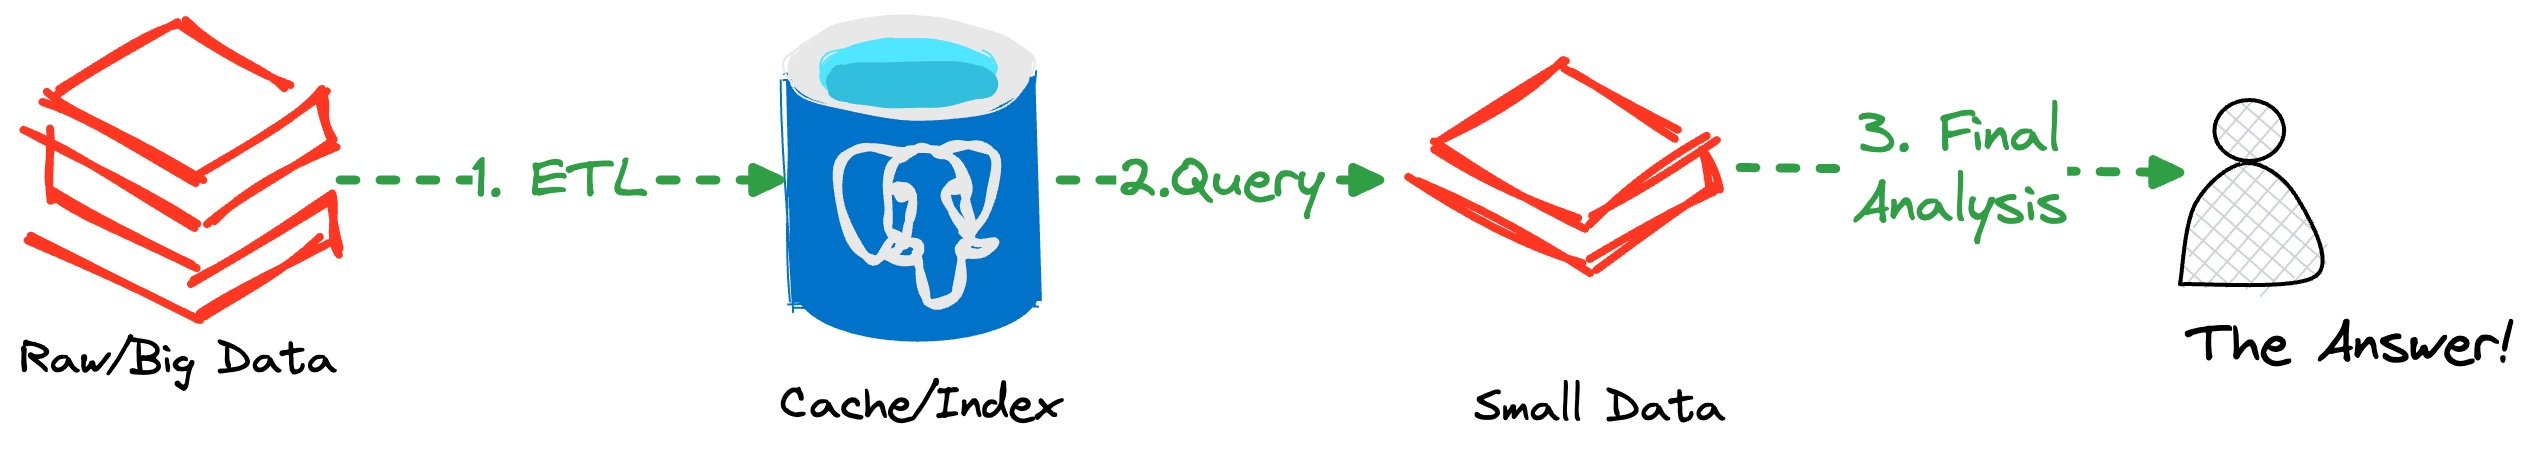

In [3]:
# Raw Data -> Index -> Retreive:  A picture is worth a thousand words
Image(filename="./images/retrieval_pipeline.jpg")

In [ ]:
# Query some young pets - using the alphabet

# Data Set small enough we can use raw data run the query and retrieval in one fell swoop
things_we_saw = [
    "dog",
    "cat",
    "zebra",
    "puppy",
    "calf",
    "puppies",
    "kitten",
    "cow",
    "desk",
    "rubber band",
    "mouse",
    "airpods",
    "smelly socks",
    "sandals",
    "jacket",
    "cats",
    "young dog",
    "young cat",
    "young hamster",
]

# The query to retreive  - but not super
retrieval_query = "puppy|kitten"
young_pets = [item for item in things_we_saw if re.match(retrieval_query, item)]


print(young_pets)

In [ ]:
# Query some young pets - using english meaning (build cache)

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma, FAISS

# Reperesent words using embedding (if time see pictures)
VectorStore = FAISS
embeddings = OpenAIEmbeddings()
db = VectorStore.from_texts(things_we_saw, embedding=embeddings)

In [ ]:
# Query some young pets - using english meaning (Embeddings)

print(db.similarity_search_with_relevance_scores("young dogs", k=5))

In [ ]:
# Innovate: Did someone have some journal entries?

script = """
mosh lightsail
z nlp
./igor-journal.py  --help

# Look at entries by date, when was covid?

./igor_journal.py entries 2020-04-30

# Wait when was I most impacted? 

 ./igor_journal.py files_with_word covid

# Lets see what was going on that day.

./igor_journal.py body 2022-04-10  
 

# Blah, wall of text, lets have Dr. GPT analyze

./life.py journal-report 2022-04-10 -u4

# Look skim the code
vim ~/gits/nlp/life.py 

# Lets look at that :) - zm to fold 
vim ~/gits/nlp/assets/report-2022-04-10.md


"""
print(script)

In [ ]:
# Aside: Walk through of Word Embeddings
# https://investigate.ai/text-analysis/word-embeddings/

### Planning - Workflow and Verifcation and Agents

In [ ]:
# Help me write a talk
notes = """
- Run auto-gpt
- Write a talk on LLMs
- Chain of Thought
- LLM to run feedback
- Agent to Run Commands
"""
print(notes)